# **Ensamble de Genomas con ONT: Paso a paso**

## Simón Villanueva Corrales


Los pasos generales para un ensamble con tecnología ONT son:

<img src="https://raw.githubusercontent.com/sivico26/notebooks/master/Pipeline/Images/steps.png" width=600>

Esta guía contiene una breve explicación de cada uno de los pasos y un caso sencillo que se utilizará para ilustrar el accionar de cada uno. 

In [117]:
mkdir Archivos_sim_ont

mkdir: cannot create directory ‘Archivos_sim_ont’: File exists


Los programas que se utilizarán en cada paso destacan por su velocidad de procesamiento más que por su precisión u otra característica.

## **Simulación de datos**

Utilizaremos [Nanosim-h](https://github.com/karel-brinda/NanoSim-H), un simulador de datos de nanopore que ya está entrenado para generar reads de ciertos organismos. Generaremos datos, ¿cómo no?, de un genoma de *E. coli* de referencia

In [43]:
!nanosim-h -h

usage: nanosim-h [-h] [-p str] [-o str] [-n int] [-u float] [-m float]
                 [-i float] [-d float] [-s int] [--circular] [--perfect]
                 [--merge-contigs] [--rnf] [--rnf-add-cigar] [--max-len int]
                 [--min-len int] [--kmer-bias int]
                 <reference.fa>

Program:  NanoSim-H - a simulator of Oxford Nanopore reads.
Version:  1.1.0.3
Authors:  Chen Yang <cheny@bcgsc.ca> - author of the original software package (NanoSim)
          Karel Brinda <kbrinda@hsph.harvard.edu> - author of the NanoSim-H fork

positional arguments:
  <reference.fa>        reference genome (- for standard input)

optional arguments:
  -h, --help            show this help message and exit
  -p str, --profile str
                        error profile - one of precomputed profiles
                        ('ecoli_R7', 'ecoli_R9_2D', 'ecoli_R9_1D',
                        'ecoli_UCSC1b', 'ecoli_R7.3', 'yeast') or own
                        directory with an error profil

In [100]:
!mkdir Archivos_sim_ont/sim_reads

In [145]:
!ls Archivos_sim_ont/

albacore_output   Ensamble	 Polishing		      sim_reads
e_coli_ref.fasta  Muestra_fast5  reads_lambda_albacore.fastq


In [147]:
!ls ~/Documents/Notebooks/Pipeline/Archivos_sim_ont/

albacore_output   Ensamble	 Polishing		      sim_reads
e_coli_ref.fasta  Muestra_fast5  reads_lambda_albacore.fastq


In [148]:
!cd Archivos_sim_ont/sim_reads/ && nanosim-h --circular -n 100 --rnf -o ec ~/Documents/Notebooks/Pipeline/Archivos_sim_ont/e_coli_ref.fasta

Using profile ecoli_R9_2D from default profiles
Simulating unaligned reads
100% (6 of 6) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
Simulating aligned reads
100% (94 of 94) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


In [116]:
!nanosim-h --circular -n 100 --rnf -o ecoli /home/sivico26/Documents/Notebooks/Pipeline/Archivos_sim_ont/e_coli.ref.fasta

usage: nanosim-h [-h] [-p str] [-o str] [-n int] [-u float] [-m float]
                 [-i float] [-d float] [-s int] [--circular] [--perfect]
                 [--merge-contigs] [--rnf] [--rnf-add-cigar] [--max-len int]
                 [--min-len int] [--kmer-bias int]
                 <reference.fa>
nanosim-h: error: argument <reference.fa>: can't open '/home/sivico26/Documents/Notebooks/Pipeline/Archivos_sim_ont/e_coli.ref.fasta': [Errno 2] No such file or directory: '/home/sivico26/Documents/Notebooks/Pipeline/Archivos_sim_ont/e_coli.ref.fasta'


## **Basecalling**


Por la naturaleza de la tecnología (una buena explicación puede encontrarse en este [video](https://nanoporetech.com/resource-centre/videos/nanopore-dna-sequencing)), los datos que genera Nanopore son series de tiempo de señal eléctrica. Es por esto que lo primero que debe hacerse es interpretar esta señal y "asignar las bases"(basecall) correspondientes a cada variación.

<img src="https://konradpaszkiewicz.files.wordpress.com/2014/04/capture5.png">

El basecaller más utilizado actualmente es Albacore, desarrollado por ONT, el cual ofrece la mejor combinación entre precisión y velocidad.

Este paso es, en nuestro caso, el cuello de botella del proceso, ya que no podemos darnos el lujo de cambiar velocidad por precisión, puesto que afectaría seriamente los pasos posteriores

In [149]:
!read_fast5_basecaller.py -r -i Archivos_sim_ont/Muestra_fast5/ -f FLO-MIN106 -k SQK-RAD002 -s Archivos_sim_ont/albacore_output -o fast5,fastq -t 4

| 100 of 100|##############################################|100% Time:  0:00:30


Verifiquemos cuantos de los reads evaluados pasaron

In [114]:
!ls Archivos_sim_ont/albacore_output/workspace/pass/0 | wc -l

63


De un total de 100 reads de prueba, 63 pasaron el basecalling con suficiente calidad (usualmente es mayor la proporción)

## **Reads QC**

Antes de empezar con los siguientes pasos veamos los reads que tenemos (del fago lambda)

El siguiente script hará un data frame de pandas para sacar los datos más relevantes de los reads.

In [138]:
from Bio import SeqIO
from Bio.SeqUtils import GC

import numpy as np
import pandas as pd
import re

#Función para hacer un dataframe de pandas desde un fasta o fastq
def read_sequence_file(filename, format):
    rows = []
    columns = ['id', 'sequence', 'read_length', 'gc_content']
    if(format == 'fastq'):
        columns.append('avg_quality')
    for seq_record in SeqIO.parse(filename, format):
        if(format == 'fastq'):
            quality_score = np.mean(seq_record.letter_annotations["phred_quality"])
        read_id = seq_record.description
        if(format == 'fastq'):
            rows.append([read_id, seq_record.seq, len(seq_record.seq), GC(seq_record.seq), quality_score])
        else:
            rows.append([read_id, seq_record.seq, len(seq_record.seq), GC(seq_record.seq)])  
        
    df = pd.DataFrame(rows, columns=columns)
    return df

In [139]:
seq_df = read_sequence_file('/home/sivico26/Documents/Notebooks/Pipeline/Archivos_sim_ont/reads_lambda_albacore.fastq', 'fastq')

In [140]:
seq_df.describe()

,read_length,gc_content,avg_quality
count,23083.000000,23083.000000,23083.000000
mean,4795.898627,49.344589,13.678540
std,6057.034726,5.959169,2.307329
min,5.000000,17.241379,4.100000
25%,1461.000000,45.213929,12.097495
50%,3008.000000,48.780488,13.734980
75%,6035.000000,54.925265,15.275225
max,193287.000000,71.949829,21.077437


¿Y eso cómo se ve? veamos unas distribuciones

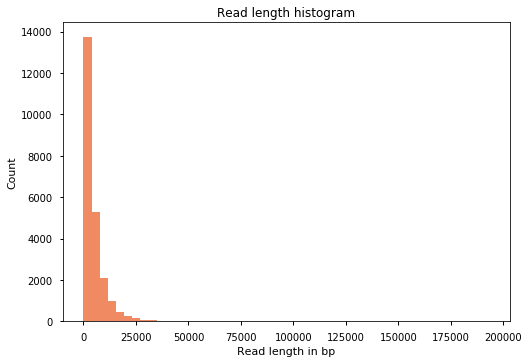

In [142]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib

#tamaño de la figura
matplotlib.rcParams['figure.figsize'] = (9, 8)

# ggplot style 
plt.style.use('seaborn-notebook')

#On the plt.hist parameters we can set the number of bins and the bar color using labels as 'blue', 'red', 'yellow'... or using a RGB code.
plt.hist(seq_df['read_length'], bins=50, color='#ef8a62')
plt.title('Read length histogram')
plt.xlabel('Read length in bp')
plt.ylabel('Count')

plt.show()

¿Y la calidad?

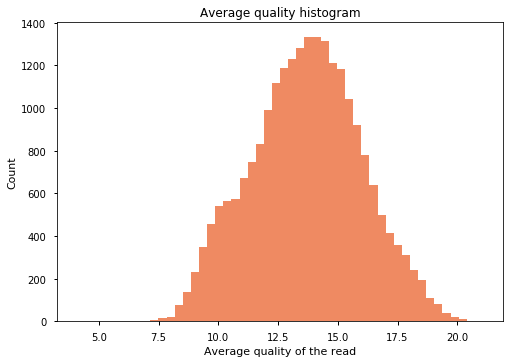

In [144]:
#Only works with FASTQ files
plt.hist(seq_df['avg_quality'], bins=50, color='#ef8a62')
plt.title('Average quality histogram')
plt.xlabel('Average quality of the read')
plt.ylabel('Count')

plt.show()

## **Read to Read Overlap**

Ya que tenemos los reads con sus bases asignadas (formato fastq o fasta), seguimos con el overlap, que es un mapeo buscando coincidencias entre los reads para posteriormente pasar al ensamble. 

De aquí en más usaremos datos del fago lambda

El programa que usaremos será [Minimap2](https://github.com/lh3/minimap2), la versión mejorada de Minimap. Minimap2 cuenta con una configuración precargada especificamente para este paso: 

In [118]:
! minimap2 -h

Usage: minimap2 [options] <target.fa>|<target.idx> [query.fa] [...]
Options:
  Indexing:
    -H           use homopolymer-compressed k-mer
    -k INT       k-mer size (no larger than 28) [15]
    -w INT       minizer window size [10]
    -I NUM       split index for every ~NUM input bases [4G]
    -d FILE      dump index to FILE []
  Mapping:
    -f FLOAT     filter out top FLOAT fraction of repetitive minimizers [0.0002]
    -g NUM       stop chain enlongation if there are no minimizers in INT-bp [5000]
    -G NUM       max intron length (effective with -xsplice; changing -r) [200k]
    -F NUM       max fragment length (effective with -xsr or in the fragment mode) [800]
    -r NUM       bandwidth used in chaining and DP-based alignment [500]
    -n INT       minimal number of minimizers on a chain [3]
    -m INT       minimal chaining score (matching bases minus log gap penalty) [40]
    -X           skip self and dual mappings (for the all-vs-all mode)
    -p FLOAT     min secondary-

In [119]:
!mkdir Archivos_sim_ont/Ensamble

In [126]:
!minimap2 -x ava-ont Archivos_sim_ont/reads_lambda_albacore.fastq Archivos_sim_ont/reads_lambda_albacore.fastq > Archivos_sim_ont/Ensamble/ovlp_fl.paf 

[M::mm_idx_gen::5.540*1.30] collected minimizers
[M::mm_idx_gen::7.445*1.73] sorted minimizers
[M::main::7.445*1.73] loaded/built the index for 23083 target sequence(s)
[M::mm_mapopt_update::8.096*1.67] mid_occ = 401
[M::mm_idx_stat] kmer size: 15; skip: 5; is_hpc: 0; #seq: 23083
[M::mm_idx_stat::8.503*1.64] distinct minimizers: 19092294 (80.61% are singletons); average occurrences: 1.968; average spacing: 2.947
[M::worker_pipeline::168.868*2.64] mapped 23083 sequences
[M::main] Version: 2.10-r761
[M::main] CMD: minimap2 -x ava-ont Archivos_sim_ont/reads_lambda_albacore.fastq Archivos_sim_ont/reads_lambda_albacore.fastq
[M::main] Real time: 168.905 sec; CPU: 445.987 sec


## **Ensamble**

Una vez hallados los overlaps, se procedeal ensamble como tal, en el que se toman los averlaps y se trata de construir en el menor número de contigs posibles (idealmente el número de contigs es igual al número de cromosomas)

Usaremos [Miniasm](https://github.com/lh3/miniasm), un ensamblador OLC desarrollado para ir de la mano con minimap.

In [127]:
!miniasm -h

miniasm: option requires an argument -- 'h'
Usage: miniasm [options] <in.paf>
Options:
  Pre-selection:
    -m INT      min match length [100]
    -i FLOAT    min identity [0.05]
    -s INT      min span [2000]
    -c INT      min coverage [3]
  Overlap:
    -o INT      min overlap [same as -s]
    -h INT      max over hang length [1000]
    -I FLOAT    min end-to-end match ratio [0.8]
  Layout:
    -g INT      max gap differences between reads for trans-reduction [1000]
    -d INT      max distance for bubble popping [50000]
    -e INT      small unitig threshold [4]
    -f FILE     read sequences []
    -n INT      rounds of short overlap removal [3]
    -r FLOAT[,FLOAT]
                max and min overlap drop ratio [0.7,0.5]
    -F FLOAT    aggressive overlap drop ratio in the end [0.8]
  Miscellaneous:
    -p STR      output information: bed, paf, sg or ug [ug]
    -b          both directions of an arc are present in input
    -1          skip 1-pass read selection
    -2         

In [129]:
!miniasm -f Archivos_sim_ont/reads_lambda_albacore.fastq Archivos_sim_ont/Ensamble/ovlp_fl.paf > Archivos_sim_ont/Ensamble/fago_lambda_raw.gfa

[M::main] ===> Step 1: reading read mappings <===
[M::ma_hit_read::25.667*1.00] read 13671141 hits; stored 17996729 hits and 13331 sequences (93372637 bp)
[M::main] ===> Step 2: 1-pass (crude) read selection <===
[M::ma_hit_sub::30.126*1.00] 12950 query sequences remain after sub
[M::ma_hit_cut::30.540*1.00] 17912211 hits remain after cut
[M::ma_hit_flt::31.055*1.00] 17110407 hits remain after filtering; crude coverage after filtering: 1015.33
[M::main] ===> Step 3: 2-pass (fine) read selection <===
[M::ma_hit_sub::33.229*1.00] 12906 query sequences remain after sub
[M::ma_hit_cut::33.629*1.00] 17084609 hits remain after cut
[M::ma_hit_contained::34.204*1.00] 16 sequences and 156 hits remain after containment removal
[M::main] ===> Step 4: graph cleaning <===
[M::ma_sg_gen] read 138 arcs
[M::main] ===> Step 4.1: transitive reduction <===
[M::asg_arc_del_trans] transitively reduced 97 arcs
[M::asg_arc_del_multi] removed 0 multi-arcs
[M::asg_arc_del_asymm] removed 3 asymmetric arcs
[M::m

Ahora cambiemos el formato a algo más conocido (gfa to fasta)

In [131]:
!awk '/^S/{print ">"$2"\n"$3}' Archivos_sim_ont/Ensamble/fago_lambda_raw.gfa | fold > Archivos_sim_ont/Ensamble/fago_lambda_raw.fasta

Ahora veamos el número de contigs del ensamble:

In [132]:
!grep -c ">" Archivos_sim_ont/Ensamble/fago_lambda_raw.fasta  

1


¡Un exitoso ensamble de un solo Contig!


## **Read Mapping**

Aunque hayamos logrado hacer un ensamble de un solo contig, es bastante probable que esté lleno de errores, por lo que hay que corregirlos. El primer paso en para hacer esto es volver a mappear los reads en al ensamble.

Para esto, volveremos a utilizar Minimap2, pero con otra configuración

In [133]:
!mkdir Archivos_sim_ont/Polishing

In [134]:
!minimap2 -x map-ont Archivos_sim_ont/Ensamble/fago_lambda_raw.fasta Archivos_sim_ont/reads_lambda_albacore.fastq > Archivos_sim_ont/Polishing/aln_fl.paf

[M::mm_idx_gen::0.005*1.30] collected minimizers
[M::mm_idx_gen::0.009*1.94] sorted minimizers
[M::main::0.009*1.93] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.009*1.84] mid_occ = 2
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.010*1.76] distinct minimizers: 9304 (100.00% are singletons); average occurrences: 1.000; average spacing: 5.324
[M::worker_pipeline::2.995*2.52] mapped 23083 sequences
[M::main] Version: 2.10-r761
[M::main] CMD: minimap2 -x map-ont Archivos_sim_ont/Ensamble/fago_lambda_raw.fasta Archivos_sim_ont/reads_lambda_albacore.fastq
[M::main] Real time: 2.997 sec; CPU: 7.561 sec


## **Polishing**

Finalmente haremos polishing, que consiste en corregir el ensamble que tenemos al compararlo nuevamente con los reads que fueron mapeados en el paso anterior

Para un polishing rápido usaremos [Racon](https://github.com/isovic/racon)

In [ ]:
!racon /home/sivico26/Documents/Notebooks/Pipeline/Archivos_sim_ont/reads_lambda_albacore.fastq /home/sivico26/Documents/Notebooks/Pipeline/Archivos_sim_ont/Polishing/aln_fl.paf /home/sivico26/Documents/Notebooks/Pipeline/Archivos_sim_ont/Ensamble/fago_lambda_raw.fasta > /home/sivico26/Documents/Notebooks/Pipeline/Archivos_sim_ont/Polishing/fago_lambda_pol.fasta

Por alguna razón el resultado no se muestra, pero `Racon` efectivamente corrió

## **Assembly QC**

¿Cómo de determinar si el ensamble es realmente bueno? suelen usarse varias métricas para evaluar el ensamble, como el número de contigs, el n50, etc; pero también se debe evaluar a precisión y para eso se debe comparar con una referencia. 

In [153]:
!quast.py -h

QUAST: Quality Assessment Tool for Genome Assemblies
Version: 5.0.0.dev0, 1563de2

Usage: python /home/sivico26/anaconda3/bin/quast.py [options] <files_with_contigs>

Options:
-o  --output-dir  <dirname>       Directory to store all result files [default: quast_results/results_<datetime>]
-r                <filename>      Reference genome file
-g  --features [type:]<filename>  File with genomic feature coordinates in the reference (GFF, BED, NCBI or TXT)
                                  Optional 'type' can be specified for extracting only a specific feature type from GFF
-m  --min-contig  <int>           Lower threshold for contig length [default: 500]
-t  --threads     <int>           Maximum number of threads [default: 25% of CPUs]

Advanced options:
-s  --scaffolds                       Assemblies are scaffolds, split them and add contigs to the comparison
-l  --labels "label, label, ..."      Names of assemblies to use in reports, comma-separated. If contain spaces, use quotes
-L 

In [156]:
!ls

Archivos_sim_ont  Edu_ont_assembly.ipynb  Images  pipeline_notes.ipynb


In [158]:
!quast.py -t 4 Archivos_sim_ont/Ensamble/fago_lambda_raw.fasta Archivos_sim_ont/Polishing/fago_lambda_pol.fasta -R Archivos_sim_ont/fago_lambda_ref.fasta -o Archivos_sim_ont/quast_results

/home/sivico26/anaconda3/lib/python3.6/site-packages/quast-5.0.0.dev0-py3.6.egg/EGG-INFO/scripts/quast.py -t 4 Archivos_sim_ont/Ensamble/fago_lambda_raw.fasta Archivos_sim_ont/Polishing/fago_lambda_pol.fasta -R Archivos_sim_ont/fago_lambda_ref.fasta -o Archivos_sim_ont/quast_results

Version: 5.0.0.dev0, 1563de2

System information:
  OS: Linux-4.13.0-38-generic-x86_64-with-debian-stretch-sid (linux_64)
  Python version: 3.6.3
  CPUs number: 8

Started: 2018-04-26 13:57:51

Logging to /home/sivico26/Documents/Notebooks/Pipeline/Archivos_sim_ont/quast_results/quast.log

CWD: /home/sivico26/Documents/Notebooks/Pipeline
Main parameters: 
  MODE: default, threads: 4, minimum contig length: 500, minimum alignment length: 65, \
  ambiguity: one, threshold for extensive misassembly size: 1000

Reference:
  /home/sivico26/Documents/Notebooks/Pipeline/Archivos_sim_ont/fago_lambda_ref.fasta ==> fago_lambda_ref

Contigs:
  Pre-processing...
  1  Archivos_sim_ont/Ensamble/fago_lambda_raw.fasta ==>